In [1]:
import os
import pickle
import sys
from argparse import ArgumentParser

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms

from hack_utils import NUM_PTS, CROP_SIZE
from hack_utils import ScaleMinSideToSize, CropCenter, TransformByKeys
from hack_utils import ThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
from hack_train import train, validate, predict

In [3]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
torch.cuda.is_available()

True

In [6]:
# 1. prepare data & models
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ("image",)),
])

In [7]:
BATCH_SIZE = 256

In [8]:
train_dataset = ThousandLandmarksDataset(os.path.join("./data", 'train'), train_transforms, split="train")
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, pin_memory=True,
                                   shuffle=True, drop_last=True)

val_dataset = ThousandLandmarksDataset(os.path.join("./data", 'train'), train_transforms, split="val")
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, pin_memory=True,
                                 shuffle=False, drop_last=False)

315144it [08:31, 615.94it/s]
393931it [02:08, 3057.32it/s]  


In [11]:
LR = 1e-3
EPOCHS = 10

In [12]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [13]:
# model = models.resnet18(pretrained=True)
# model = models.resnet34(pretrained=True)
model = models.resnet50(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR, amsgrad=True)
lr_scheduler = ReduceLROnPlateau(optimizer, patience=1, factor=0.9) 
loss_fn = fnn.mse_loss

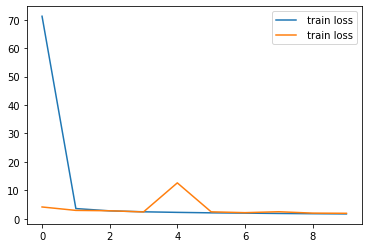

Epoch # 9:	train loss:   1.7	val loss:   1.9


In [14]:
best_val_loss = np.inf
train_loss_history = []
val_loss_history = []

for epoch in range(EPOCHS):
    
    # TRAIN ------------------------------------------
    model.train()
    train_loss = []
    for batch in tqdm.tqdm(train_dataloader, total=len(train_dataloader), desc="training..."):
        images = batch["image"].to(device)  
        landmarks = batch["landmarks"]

        pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = np.mean(train_loss)
    train_loss_history.append(train_loss.item())
    lr_scheduler.step(train_loss_history[-1])
    # -------------------------------------------------
    
    
    # TEST ------------------------------------------
    model.eval()
    val_loss = []
    for batch in tqdm.tqdm(val_dataloader, total=len(val_dataloader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    val_loss = np.mean(val_loss)
    val_loss_history.append(val_loss)
    # -------------------------------------------------
    
    # PLOT---------------------------------------------
    clear_output(True)
    plt.plot(train_loss_history, label=' train loss')
    plt.plot(val_loss_history, label=' train loss')
    plt.legend()
    plt.show()
    # -------------------------------------------------
    
    print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(f"baseline_best.pth", "wb") as fp:
            torch.save(model.state_dict(), fp)

In [ ]:
Epoch # 4:	train loss: 3.7e+01	val loss: 3.3e+01
Epoch # 1:	train loss: 1.1e+01	val loss:   6.0
Epoch # 2:	train loss: 1.1e+01	val loss:   7.3
Epoch # 4:	train loss:   4.8	val loss:   4.3
Epoch # 9:	train loss:   7.2	val loss:   7.0
Epoch # 0:	train loss: 7.1e+01	val loss:   4.8
Epoch # 4:	train loss:   2.3	val loss:   2.3

In [15]:
# 3. predict
test_dataset = ThousandLandmarksDataset(os.path.join("./data", 'test'), train_transforms, split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True,
                                  shuffle=False, drop_last=False)

99820it [00:00, 397761.52it/s]


In [16]:
with open(f"baseline_best.pth", "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [17]:
test_predictions = predict(model, test_dataloader, device)

test prediction...: 100%|██████████| 390/390 [00:57<00:00,  6.74it/s]


In [18]:
create_submission("./data", test_predictions, f"baseline_best_submit_9.csv")